#Librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

#Funciones

## Presión efectiva a un nivel z

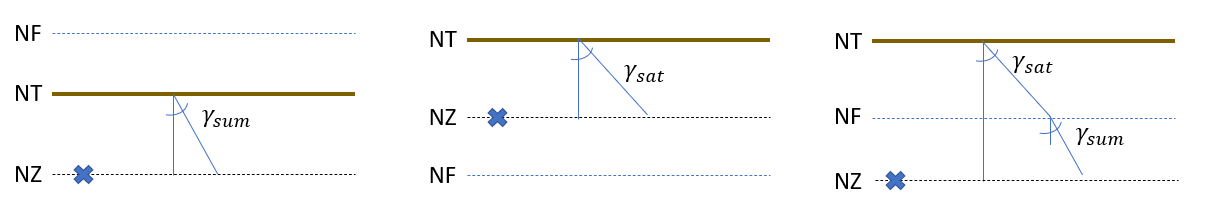

In [2]:
#Inputs
  # NZ: nivel donde queremos calcular la presión (m)
  # NT: nivel del terreno (m)
  # NF: nivel freático (m)
  # Psat: peso saturado (kN/m3)

#Outputs
  #sv_p: presión efectiva vertical (kPa)

def f_sv_p(NZ,NF,NT,Psat):

  Psum = Psat-10 #peso sumergido
  
  z = NT-NZ

  if NF>NT:
    sv_p=Psum*z
  elif NF<=NT:
    if z<=(NT-NF):
      sv_p=Psat*z
    elif z>(NT-NF):
      sv_p=Psat*(NT-NF)+Psum*(z-(NT-NF))

  return sv_p

## Capacidad de carga por punta

### Brinch Hansen

In [3]:
#Inputs
  # D: diámetro del pilote (m)
  # NT: nivel del terreno (m)
  # NF: nivel freático (m)
  # NP: nivel de la punta del pilote (m)
  # fi: ángulo de fricción efectivo (deg)
  # c: cohesión efectiva (kPa)
  # Psat: peso saturado (kN/m3)

#Outputs
  #Qu: resistencia última de la punta (kN)

def Qu_bh(D,NT,NF,NP,fi,c,Psat):                                  
  Ap = np.pi/4*(D**2) #area de la sección
  fi_r = np.deg2rad(fi) #ángulo de fricción en radianes

  zp = NT-NP #longitud del pilote

  #Cálculo de presión efectiva vertical
  sv_p=f_sv_p(NP,NF,NT,Psat) #llamo a la función de presión vertical y entro con NZ=NP

  #Cálculo de capacidad de carga s/ Brinch-Hansen
  Nq = np.e**(np.pi*np.tan(fi_r))*np.tan(np.pi/4+(fi_r)/2)**2

  if fi<=0:
    Nc = 5.14
  elif fi>0:
    Nc = (Nq-1)*1/np.tan(fi_r)

  dc = 1+0.4*np.arctan(zp/D)
  dq = 1+2*np.tan(fi_r)*(1-np.sin(fi_r))**2*np.arctan(zp/D)

  sc = 1+Nq/Nc
  sq = 1+np.tan(fi_r)

  qu = c*Nc*dc*sc + sv_p*Nq*sq*dq
  Qu = qu*Ap
  return Qu

### Vesic

In [4]:
#Inputs
  # D: diámetro del pilote (m)
  # NT: nivel del terreno (m)
  # NF: nivel freático (m)
  # NP: nivel de la punta del pilote (m)
  # fi: ángulo de fricción efectivo (deg)
  # c: cohesión efectiva (kPa)
  # G: módulo de corte (MPa)
  # OCR: grado de sobreconsolidación (-)
  # Psat: peso saturado (kN/m3)

#Outputs
  #Qu: resistencia última de la punta (kN)

def Qu_vesic(D,NT,NF,NP,fi,c,G,OCR,Psat):                                
  Ap = np.pi/4*(D**2) #area de la sección
  fi_r = np.deg2rad(fi) #ángulo de fricción en radianes

  zp = NT-NP #longitud del pilote

  #Cálculo de presión efectiva vertical
  sv_p=f_sv_p(NP,NF,NT,Psat) #llamo a la función de presión vertical y entro con NZ=NP

  #Coeficiente de empuje en reposo
  K0_nc = 1 - np.sin(fi_r) #normalmente consolidado
  K0 = K0_nc*(OCR)**np.sin(fi_r) #sobre-consolidado

  p = (1+2*K0)/3*sv_p #presion media

  #Fórmulas de Vesic
  Ir = G*1000 / (c+p*np.tan(fi_r))
  ev = 50*Ir**(-1.8)
  Irr = Ir / (1+ev*Ir)

  c1 = 3/(3-np.sin(fi_r))*np.e**(np.pi/2-fi_r)*np.tan(fi_r)
  c3 = 4/3*np.sin(fi_r)/(1+np.sin(fi_r))

  Nsg = c1*np.tan(np.pi/4+fi_r/2)**2*Irr**c3
  if fi_r<=0:
    Nc = 5.14
  elif fi_r>0:
    Nc = 1/np.tan(fi_r)*((1+2*K0)/3*Nsg-1)

  qu = c*Nc + p*Nsg
  Qu = qu*Ap
  return Qu

## Capacidad de carga por fuste

### Drenado

In [26]:
#Inputs
  # D: diámetro del pilote (m)
  # NT: nivel del terreno (m)
  # NF: nivel freático (m)
  # NP: nivel de la punta del pilote (m)
  # fi: ángulo de fricción efectivo (deg)
  # c: cohesión efectiva (kPa)
  # OCR: grado de sobreconsolidación (-)
  # Psat: peso saturado (kN/m3)

#Outputs
  #Qu: resistencia última por fuste (kN)

def Qufdr(D,NT,NF,NP,fi,c,OCR,Psat):                             
  Up = np.pi*D   #perímetro de la sección 
  fi_r = np.deg2rad(fi) #ángulo de fricción en radianes

  # zp = NT-NP #longitud del pilote

  #Empuje horizontal en reposo
  K0_nc = 1 - np.sin(fi_r) #normalmente consolidado
  K0 = K0_nc*(OCR)**np.sin(fi_r) #sobreconsolidado
  K = 0.75

  delta_r = 0.75*fi_r #fricción interfaz hormigón-terreno

  #Integración de la resistencia por fuste
  z=np.linspace(NT,NP,num=10) #creo un de n cotas en la longitud del pilote
  dz=z[0]-z[1] #calculo el dz

  Quf=0 #creo una variable en donde voy a ir sumando las resistencias
  
  for i in range(z.size): #barro todos los puntos del pilote
    NZ=z[i] #me fijo en que cota estoy
    sv_p=f_sv_p(NZ,NF,NT,Psat) #calculo la presión vertical efectiva
    fs = K*sv_p*np.tan(delta_r) #calculo la resistencia a fricción unitaria
    Quf=Quf+fs*dz*Up #calculo la fuerza en un dz x el perímetro y lo sumo a la resistencia total

  return Quf

a=Qufdr(0.6,0,-3,-8,32,10,0,19)
b=Qufdr(0.6,-8,-3,-12,37,30,0,19)
print(a+b)

391.4679676699003


### No drenado

In [6]:
#Inputs
  # D: diámetro del pilote (m)
  # NT: nivel del terreno (m)
  # NF: nivel freático (m)
  # NP: nivel de la punta del pilote (m)
  # fi: ángulo de fricción efectivo (deg)
  # c: cohesión efectiva (kPa)
  # OCR: grado de sobreconsolidación (-)
  # Psat: peso saturado (kN/m3)

#Outputs
  #Qu: resistencia última por fuste (kN)

def Qufnd(D,NT,NF,NP,s_u): 
  Up = np.pi*D
  zp = NT-NP

  alfa = np.min([0.21+26/s_u,1])
  fs = alfa*s_u

  Quf = zp*Up*fs
  return Quf

#Ejemplo - deterministico

Datos

In [7]:
# Pilote
D = 0.60        # diámetro del pilote, en m
NT = 0          # nivel de terreno, en m
NF = -2         # nivel freático, en m
NP = -10        # nivel de punta del pilote, en m

# Suelo (drenado)
fi_ef = 31      # ángulo de fricción efectivo del suelo, en grados
c_ef = 10       # cohesión efectiva del suelo, en kPa

# Suelo (no-drenado)
fi_u = 0        # ángulo de fricción no drenado del suelo, en grados
c_u = 150        # cohesión no drenada del suelo, en kPa

# Suelo (otros parámetros)
E = 90          # módulo de elasticidad horizontal, en MPa
nu = 0.20       # módulo de Poisson
G = E/2/(1+nu)  # módulo de corte, en MPa
OCR = 2         # Factor de sobreconsolidación
Psat = 19       # peso específico saturado del suelo, en kN/m3

## Drenado

In [8]:
# Resistencia por punta (Brinch-Hansen)
Qu_p1=Qu_bh(D,NT,NF,NP,fi_ef,c_ef,Psat)
print(f'Resistencia por punta Brinch-Hansen: {Qu_p1:.0f} kN')

# Resistencia por punta (Vesic)
Qu_p2=Qu_vesic(D,NT,NF,NP,fi_ef,c_ef,G,OCR,Psat)
print(f'Resistencia por punta Vesic: {Qu_p2:.0f} kN')

#Se adopta la menor de las dos
Qu_p=np.min([Qu_p1,Qu_p2])

# Resistencia por fuste
Qu_f=Qufdr(D,NT,NF,NP,fi_ef,c_ef,OCR,Psat)

print(f'Resistencia por fuste drenado: {Qu_f:.0f} kN')

#Resistencia total
Qu_dr = Qu_p + Qu_f

print(f'Resistencia última drenada: {Qu_dr:.0f} kN')

Resistencia por punta Brinch-Hansen: 1708 kN
Resistencia por punta Vesic: 2909 kN
Resistencia por fuste drenado: 360 kN
Resistencia última drenada: 2068 kN


## No drenado

In [9]:
# Resistencia por punta (Brinch-Hansen)
Qu_p1=Qu_bh(D,NT,NF,NP,fi_u,c_u,Psat)
print(f'Resistencia por punta Brinch-Hansen: {Qu_p1:.0f} kN')

# Resistencia por punta (Vesic)
Qu_p2=Qu_vesic(D,NT,NF,NP,fi_u,c_u,G,OCR,Psat)
print(f'Resistencia por punta Vesic: {Qu_p2:.0f} kN')

#Se adopta la menor de las dos
Qu_p=np.min([Qu_p1,Qu_p2])

# Resistencia por fuste
Qu_f=Qufnd(D,NT,NF,NP,c_u)

print(f'Resistencia por fuste: {Qu_f:.0f} kN')

#Resistencia total
Qu_nd = Qu_p + Qu_f

print(f'Resistencia última no drenada: {Qu_nd:.0f} kN')

Resistencia por punta Brinch-Hansen: 449 kN
Resistencia por punta Vesic: 218 kN
Resistencia por fuste: 1084 kN
Resistencia última no drenada: 1302 kN


#Ejemplo - probabilístico

En condiciones no drenadas

Datos determinísticos

In [10]:
# Pilote
D = 0.76   # diámetro del pilote, en m
NT = 0   # nivel de terreno, en m
NF = -6   # nivel freático, en m
NP = -10   # nivel de punta del pilote, en m

# Suelo (no-drenado)
fi_u = 0   # ángulo de fricción no drenado del suelo, en grados

# Suelo (otros parámetros)
E = 35    # módulo de elasticidad horizontal, en MPa
nu = 0.20    # módulo de Poisson
G = E/2/(1+nu)   # módulo de corte, en MPa
OCR = 7.3   # Factor de sobreconsolidación
Psat = 20.6   # peso específico saturado del suelo, en kN/m3

Datos estocásticos

In [11]:
c_u_media = 150 # cohesión no drenada del suelo media, en kPa
c_u_std = 45 #desvio estandar de la cohesión (30%), en kPa

#Asumo una distribución normal de los parámetros y genero n muestras aleatorias
n=10000
c_u_al=np.random.normal(c_u_media,c_u_std,n)

# print(c_u_al)

Distribución de su

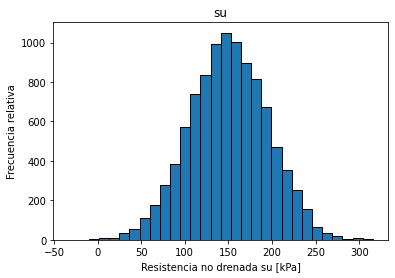

In [12]:
plt.hist(c_u_al,30,edgecolor='black', linewidth=1.0)
plt.xlabel("Resistencia no drenada su [kPa]")
plt.ylabel("Frecuencia relativa")
plt.title('su')

plt.show()

Cálculo de resistencia

In [13]:
Qu_nd_al = np.zeros(n)

for i in range(n):
  c_u = c_u_al[i]
  Qu_p1=Qu_bh(D,NT,NF,NP,fi_u,c_u,Psat) # resistencia por punta (Brinch-Hansen)
  Qu_p2=Qu_vesic(D,NT,NF,NP,fi_u,c_u,G,OCR,Psat) # resistencia por punta (Vesic)
  Qu_p=np.min([Qu_p1,Qu_p2]) # resistencia por punta, en kN
  Qu_f=Qufnd(D,NT,NF,NP,c_u) # Resistencia por fuste, en kN
  Qu_nd = Qu_p + Qu_f #resistencia no drenada total, en kN
  Qu_nd_al[i] = Qu_nd

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


Distribución de Qu no drenada

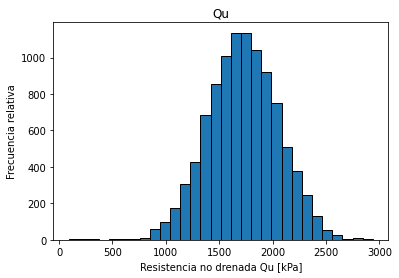

In [14]:
plt.hist(Qu_nd_al,30,edgecolor='black', linewidth=1.0)
plt.xlabel("Resistencia no drenada Qu [kPa]")
plt.ylabel("Frecuencia relativa")
plt.title('Qu')

plt.show()

Resistencia característica

Determinamos cual es la resistencia que nos da una confiabilidad de 95%

In [15]:
#Ordenamos el vector con resultados
Qu_nd_al_ordenado = np.sort(Qu_nd_al)

#Calculamos que posición del vector corresponde al 5%
n5=int(np.round(n*0.05,decimals=0))

#Sacamos el valor que está en dicha posición
Quc = Qu_nd_al_ordenado[n5]


print(f'Resistencia última no drenada con una confianza del 95%: {Quc:.0f} kN')

Resistencia última no drenada con una confianza del 95%: 1180 kN
